In [ ]:
!!pip install -q git+https://github.com/keras-team/keras-nlp.git --upgrade

In [ ]:
import keras_nlp

Using TensorFlow backend


In [ ]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split

# Load and Prepare Data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/PSUT/Graduation-Project2/rehab-ai-data/KiMoRe_final/KiMoRe_Es4_movenet.csv")

In [ ]:
df

,ID,exercise,video,joint_positions,clinical_score,#frames
0,P_ID11,Es4,/content/drive/MyDrive/PSUT/Graduation-Project...,/content/drive/MyDrive/PSUT/Graduation-Project...,15.333333,363
1,P_ID16,Es4,/content/drive/MyDrive/PSUT/Graduation-Project...,/content/drive/MyDrive/PSUT/Graduation-Project...,30.000000,746
2,P_ID10,Es4,/content/drive/MyDrive/PSUT/Graduation-Project...,/content/drive/MyDrive/PSUT/Graduation-Project...,32.149872,563
3,P_ID4,Es4,/content/drive/MyDrive/PSUT/Graduation-Project...,/content/drive/MyDrive/PSUT/Graduation-Project...,14.000000,941
4,P_ID3,Es4,NaN,NaN,-1.000000,0
...,...,...,...,...,...,...
73,E_ID4,Es4,/content/drive/MyDrive/PSUT/Graduation-Project...,/content/drive/MyDrive/PSUT/Graduation-Project...,44.333333,538
74,E_ID6,Es4,/content/drive/MyDrive/PSUT/Graduation-Project...,/content/drive/MyDrive/PSUT/Graduation-Project...,42.666667,415
75,E_ID1,Es4,/content/drive/MyDrive/PSUT/Graduation-Project...,/content/drive/MyDrive/PSUT/Graduation-Project...,50.000000,1422
76,E_ID7,Es4,/content/drive/MyDrive/PSUT/Graduation-Project...,/content/drive/MyDrive/PSUT/Graduation-Project...,44.333333,554


In [ ]:
def get_dataframe_cols():
  KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
  }
  df_cols = []
  for keypoint_name in KEYPOINT_DICT:
    df_cols.append(f"{keypoint_name}_y")
    df_cols.append(f"{keypoint_name}_x")
    df_cols.append(f"{keypoint_name}_confidence")
  return df_cols

In [ ]:
all_cols = get_dataframe_cols()
face_cols = all_cols[:15]
cols_drop = face_cols
print(f"Dropping {len(cols_drop)} columns.")

Dropping 15 columns.


In [ ]:
EXERCISE = "Es4"
EXERCISE_VIDO_MAX_LEN = df[df['exercise'] == EXERCISE]['#frames'].max()
print(f"Maximum video length: {EXERCISE_VIDO_MAX_LEN}")

def prepare_data(df, exercise_video_max_len, data_type):
  data = []
  labels = []
  padding_masks = []

  for index, row in df.iterrows():
    joint_positions_path = row['joint_positions']
    if joint_positions_path is np.NAN:
      continue
    clinical_score = row['clinical_score']
    video_length = row['#frames']

    joint_positions_data = pd.read_csv(joint_positions_path)
    joint_positions_data = joint_positions_data.drop(cols_drop, axis=1)
    joint_positions_data = joint_positions_data.to_numpy()

    padding_length = exercise_video_max_len - video_length
    padding_mask = np.zeros((video_length + padding_length))
    padding_mask[-padding_length:] = 1

    joint_positions_data_padded = np.pad(joint_positions_data, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)

    data.append(joint_positions_data_padded)
    labels.append(clinical_score)
    padding_masks.append(padding_mask)

  data = np.array(data)
  labels = np.array(labels)
  padding_masks = np.array(padding_masks)

  data = np.nan_to_num(data)
  labels = np.nan_to_num(labels)

  print(f"{data_type} Data Shape:", data.shape)
  print(f"{data_type} Labels Shape:", labels.shape)
  print(f"{data_type} Padding Masks Shape:", padding_masks.shape)

  return (data, padding_masks), labels

Maximum video length: 1988


In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=0)

In [ ]:
train_data, train_labels = prepare_data(train, EXERCISE_VIDO_MAX_LEN, "Train")
test_data, test_labels = prepare_data(test, EXERCISE_VIDO_MAX_LEN, "Test")

Train Data Shape: (57, 1988, 36)
Train Labels Shape: (57,)
Train Padding Masks Shape: (57, 1988)
Test Data Shape: (15, 1988, 36)
Test Labels Shape: (15,)
Test Padding Masks Shape: (15, 1988)


# Build Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import regularizers
from keras.regularizers import l2, l1

In [ ]:
num_joints=train_data[0][0].shape[1]
num_windows=4
window_size=497
num_heads=4
d_model=10
dense_units=64

In [ ]:
inputs = tf.keras.Input(shape=(train_data[0][0].shape[0], train_data[0][0].shape[1]), name='orignal_data')

masks = tf.keras.Input(shape=(train_data[1].shape[1]), name='padding_masks')

windows = tf.split(inputs, num_windows, axis=1)
print("Windows:")
for window in windows:
  print(window.shape)

windows_masks = tf.split(masks, num_windows, axis=1)
print("Windows Masks:")
for mask in windows_masks:
  print(mask.shape)

embedding_layer = tf.keras.layers.Dense(18, activation='relu')
#embedding_layer2 = tf.keras.layers.Dense(16, activation='relu')
embedding_layer3 = tf.keras.layers.Dense(10, activation='relu')

embeddings = []
for window in windows:
    embedding = embedding_layer(window)
    #embedding = embedding_layer2(embedding)
    embedding = embedding_layer3(embedding)
    embeddings.append(embedding)

print("Embeddings:")
for embd in embeddings:
  print(embd.shape)

positional_embedding_layer = tf.keras.layers.Embedding(input_dim=window_size, output_dim=d_model)
positional_embeddings = []
for i in range(num_windows):
    positional_embedding = positional_embedding_layer(tf.range(window_size))
    positional_embeddings.append(positional_embedding)

print("Positional Embeddings:")
for pos_embd in positional_embeddings:
  print(pos_embd.shape)

embeddings_all = [embedding + positional_embedding for embedding, positional_embedding in zip(embeddings, positional_embeddings)]
print("All Embeddings:")
for embd in embeddings_all:
  print(embd.shape)

transformer_encoder_layer = keras_nlp.layers.TransformerEncoder(intermediate_dim=d_model, num_heads=num_heads)
encoded = [transformer_encoder_layer(window_embd, window_mask) for window_embd, window_mask in zip(embeddings, windows_masks)]
print("Encodings:")
for enc in encoded:
  print(enc.shape)

concat_output = tf.concat(encoded, axis=1)
print(f"Concat: {concat_output.shape}")

flatten_output = tf.keras.layers.Flatten()(concat_output)
print(f"Flatten: {flatten_output.shape}")

#dense_output = tf.keras.layers.Dense(9940, activation='relu', kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01),
                                     #bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.01))(flatten_output)
dense_output = tf.keras.layers.Dense(4970, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(flatten_output)
#dense_output = tf.keras.layers.Dense(2485, activation='relu', kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01),
                                     #bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.01))(dense_output)
#dense_output = tf.keras.layers.Dense(1242, activation='relu', kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01),
                                     #bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.01))(dense_output)
dense_output = tf.keras.layers.Dense(621, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(dense_output)
#dense_output = tf.keras.layers.Dense(310, activation='relu', kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01),
                                     #bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.01))(dense_output)
#dense_output = tf.keras.layers.Dense(155, activation='relu', kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01),
                                     #bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.01))(dense_output)
dense_output = tf.keras.layers.Dense(77, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(dense_output)
#dense_output = tf.keras.layers.Dense(38, activation='relu', kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01),
                                     #bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.01))(dense_output)
#dense_output = tf.keras.layers.Dense(19, activation='relu', kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01),
                                     #bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.01))(dense_output)
print(f"Final Dense: {dense_output.shape}")

#drop_out = tf.keras.layers.Dropout(0.2)(dense_output)

output = tf.keras.layers.Dense(1)(dense_output)

model = tf.keras.Model(inputs=[inputs, masks],
                       outputs=output,
                       name='transformer_model')

Windows:
(None, 497, 36)
(None, 497, 36)
(None, 497, 36)
(None, 497, 36)
Windows Masks:
(None, 497)
(None, 497)
(None, 497)
(None, 497)
Embeddings:
(None, 497, 10)
(None, 497, 10)
(None, 497, 10)
(None, 497, 10)
Positional Embeddings:
(497, 10)
(497, 10)
(497, 10)
(497, 10)
All Embeddings:
(None, 497, 10)
(None, 497, 10)
(None, 497, 10)
(None, 497, 10)
Encodings:
(None, 497, 10)
(None, 497, 10)
(None, 497, 10)
(None, 497, 10)
Concat: (None, 1988, 10)
Flatten: (None, 19880)
Final Dense: (None, 77)


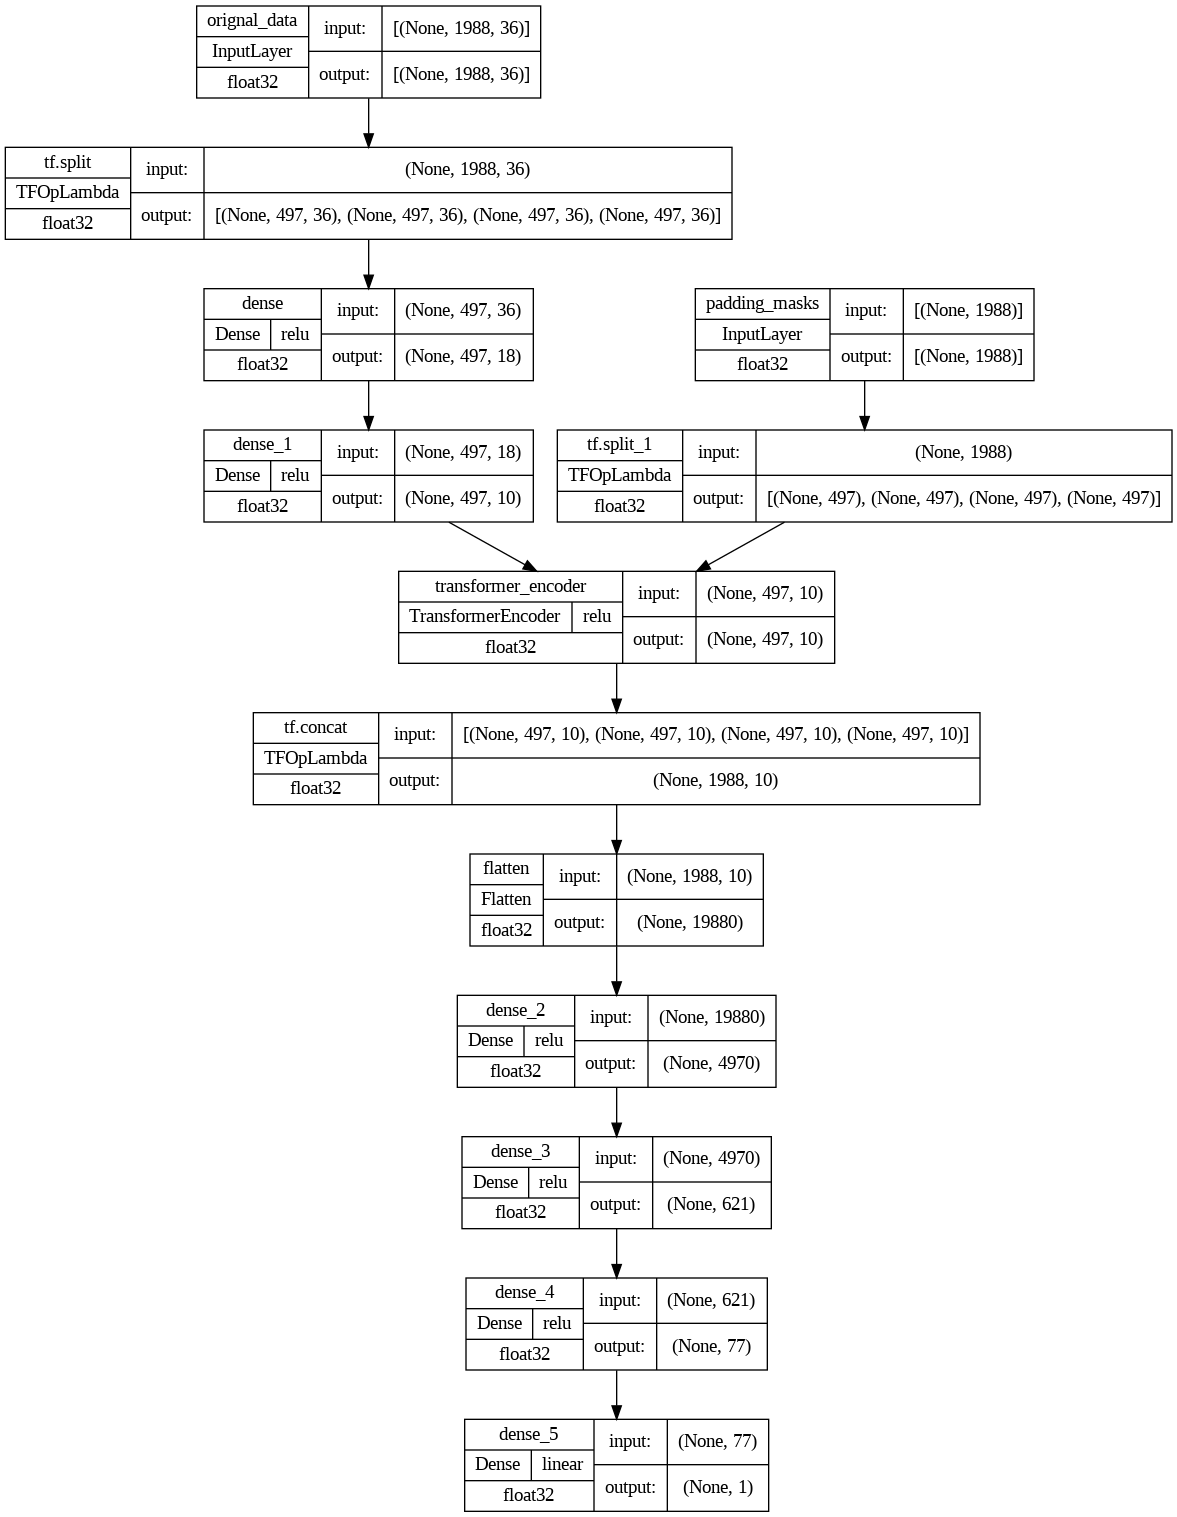

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_activations=True)

In [ ]:
for i in range(len(model.weights)):
    model.weights[i]._handle_name = model.weights[i].name + "_" + str(i)

In [ ]:
learning_rate=0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/PSUT/Graduation-Project2/code/models/checkpoints/'
checkpoint_filepath = os.path.join(checkpoint_dir, 'skipdense-l2-weights.{epoch:02d}-{val_mae:.2f}.hdf5')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mae',
    save_best_only=False)

In [ ]:
%%time
history = model.fit([train_data[0], train_data[1]], train_labels, epochs=55, validation_data=([test_data[0], test_data[1]], test_labels),
                    callbacks=[model_checkpoint_callback], batch_size=32)

Epoch 1/55
2/2 [==============================] - 24s 10s/step - loss: 4386.2441 - mae: 56.6885 - val_loss: 990.0290 - val_mae: 28.8403
Epoch 2/55
2/2 [==============================] - 20s 14s/step - loss: 1817.7759 - mae: 31.5241 - val_loss: 461.5249 - val_mae: 17.6098
Epoch 3/55
2/2 [==============================] - 17s 9s/step - loss: 355.3387 - mae: 13.0875 - val_loss: 191.9256 - val_mae: 7.9292
Epoch 4/55
2/2 [==============================] - 18s 11s/step - loss: 273.5028 - mae: 11.2466 - val_loss: 380.7486 - val_mae: 15.4684
Epoch 5/55
2/2 [==============================] - 17s 10s/step - loss: 279.8713 - mae: 11.2447 - val_loss: 163.1481 - val_mae: 7.2128
Epoch 6/55
2/2 [==============================] - 16s 10s/step - loss: 226.6130 - mae: 9.4869 - val_loss: 342.0978 - val_mae: 14.0222
Epoch 7/55
2/2 [==============================] - 18s 12s/step - loss: 246.9534 - mae: 10.1258 - val_loss: 207.1883 - val_mae: 8.6437
Epoch 8/55
2/2 [==============================] - 18s 13s/

In [ ]:
model.summary()

Model: "transformer_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 orignal_data (InputLayer)   [(None, 1988, 36)]           0         []                            
                                                                                                  
 tf.split (TFOpLambda)       [(None, 497, 36),            0         ['orignal_data[0][0]']        
                              (None, 497, 36),                                                    
                              (None, 497, 36),                                                    
                              (None, 497, 36)]                                                    
                                                                                                  
 dense (Dense)               (None, 497, 18)              666       ['tf.split[0][

## Model History

In [ ]:
import matplotlib.pyplot as plt

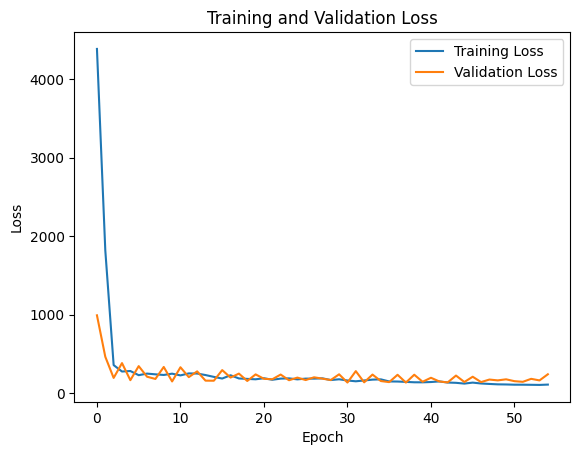

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

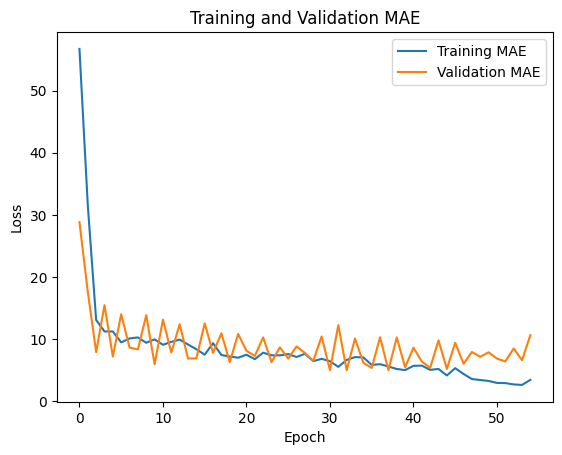

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']

epochs = range(len(loss))
plt.plot(epochs, mae, label='Training MAE')
plt.plot(epochs, val_mae, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test on Unseen Data - Make Predictions

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
model.load_weights("/content/drive/MyDrive/PSUT/Graduation-Project2/code/models/checkpoints/skipdense-l2-weights.45-5.22.hdf5")

In [ ]:
pred_train = model.predict([train_data[0], train_data[1]])
pred_test = model.predict([test_data[0], test_data[1]])

1/1 [==============================] - 1s 988ms/step


In [ ]:
print(f"Train predictions shape: {pred_train.shape}")
print(f"Test predictions shape: {pred_test.shape}")

In [ ]:
train_mae = mean_absolute_error(train_labels, pred_train)
test_mae = mean_absolute_error(test_labels, pred_test)

print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")

Train MAE: 6.227739128031772
Test MAE: 5.218403407233369


# Plot Predictions

In [ ]:
def plot_predictions(train_preds, train_labels, test_preds, test_labels):
  # Plot the predictions
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(train_preds, 's', color='red', label='Prediction', linestyle='None', alpha=0.5, markersize=6)
  plt.plot(train_labels, 'o', color='green', label='Clinical Score', alpha=0.4, markersize=6)
  #plt.ylim([-1, 51])
  plt.title('Training Set', fontsize=18)
  plt.xlabel('Sequence Number', fontsize=16)
  plt.ylabel('Clinical Score Scale', fontsize=16)
  plt.legend(loc=3, prop={'size': 14})  # loc:position

  plt.subplot(2, 1, 2)
  plt.plot(test_preds, 's', color='red', label='Prediction', linestyle='None', alpha=0.5, markersize=6)
  plt.plot(test_labels, 'o', color='green', label='Clinical Score', alpha=0.4, markersize=6)
  plt.title('Testing Set', fontsize=18)
  #plt.ylim([-1, 51])
  plt.xlabel('Sequence Number', fontsize=16)
  plt.ylabel('Clinical Score Scale', fontsize=16)
  plt.legend(loc=3, prop={'size': 14})  # loc:position

  plt.tight_layout()
  #plt.savefig('path/to/save/plot.png', dpi=300)
  plt.show()

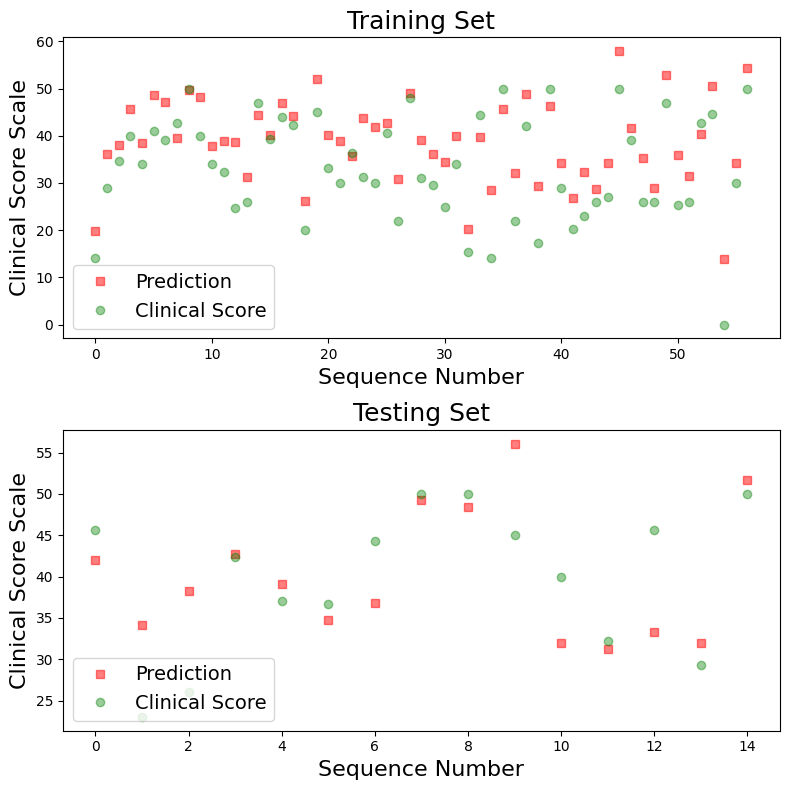

In [ ]:
plot_predictions(pred_train, train_labels, pred_test, test_labels)

# Cross Validation

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
def cross_validate(model, data, labels, padding_masks, k=5):
  y_true, y_pred, histories = list(), list(), list()
  i = 1
  kfold = KFold(n_splits=k, random_state=0, shuffle=True)
  print(f"Cross Validating Model Using {k} Folds...")
  for train_idx, val_idx in kfold.split(data):
    X_train, X_val = data[train_idx], data[val_idx]
    padding_train, padding_val = padding_masks[train_idx], padding_masks[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    history = model.fit([X_train, padding_train], y_train, epochs=100, validation_data=([X_val, padding_val], y_val), verbose=1)

    val_pred = model.predict(X_val)

    y_true.extend(y_val)
    y_pred.extend(val_pred)
    histories.append(history)

    fold_mae = mean_absolute_error(y_val, val_pred)
    print(f'- MAE of fold {i} = {fold_mae}')
    i = i+1

  mae = mean_absolute_error(y_true, y_pred)
  print(f'OOF MAE = {mae}')

In [ ]:
(all_data, all_padding), all_labels = prepare_data(df, EXERCISE_VIDO_MAX_LEN, "All Data")

All Data Data Shape: (72, 1988, 36)
All Data Labels Shape: (72,)
All Data Padding Masks Shape: (72, 1988)


In [ ]:
cross_validate(model, all_data, all_labels, all_padding)

Cross Validating Model Using 5 Folds...
Epoch 1/100
2/2 [==============================] - 34s 13s/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/100
1/2 [==============>...............] - ETA: 10s - loss: nan - mae: nan

KeyboardInterrupt: ignored